#### source: https://github.com/google-research/bert/blob/master/README.md

### BERT fine-tune can break down into three steps
### 1. prepare your own data
### 2. edit run_classifier.py class 'processor'
### 3. execute run_classifier.py and set parameters
### 4. extract the bert feature(concate last 4 layers and take average) into the json file type 
### This document is edited by Yao-Ting, Wang. Any suggestion or guidance please email me :) a26006587@gmail.com

# ---------------------------------------------------

#### 1. prepare your own data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
### clean content info
df_content = pd.read_csv('../article_contents.csv').drop(columns = ['Unnamed: 0'])
df_cate = pd.read_csv('../cw-article.csv').rename({'id':'pid'},axis = 'columns')
### about 300 articles have mutiple class, not a huge number, but if we want to improve the performance of classifer, it might be better to use a ML to re-classify the labels
### we keep the first class only here
df_cate = pd.DataFrame.drop_duplicates(df_cate , subset = 'pid',keep = 'first')

### merge the content info
df = pd.merge(df_content,df_cate[['pid','author','type','masterChannelTitle','onlineTime']],how = 'left',on = 'pid')
### To fine-tune the bert, all data must have label, so around 200 article are without labels, drop them first.
df = df.dropna(axis = 0,subset = ['masterChannelTitle'] )

### cleaning the sentences and remove pattern like <p>, </p>, etc..
df['文章內容'] = df['文章內容'].str.replace('<.*?>','')
df['文章內容'] = df['文章內容'].str.replace('\r|&[a-z]','')
df['文章內容'] = df['文章內容'].replace('',np.nan)
list_content_empty = []
pid_content_empty = []
for i in range(len(df)):
    if type(df.iloc[i,2]) is not str:
        pid_content_empty.append(df.iloc[i,0])
        list_content_empty.append(df.index[i])
df.drop(list_content_empty, inplace = True)

### label-encode the master channel to make it compatible to bert fine-tune config.
cate_dict = {
    '教育':0,
    '產業':1, 
    '財經時事':2,
    '經營管理':3, 
    '政治社會':4, 
    '經濟學人':5, 
    '環境':6, 
    '人物觀點':7,
    '專欄':8,
    '國際':9, 
    '健康關係':10, 
    '時尚生活':11, 
    '調查':12, 
    '數據圖表':13,
    '天下雜誌部落格':14, 
    '互動圖表':15, 
    '@想像未來':16,
    '天下Talk':17}
df['cate_label'] = df.apply(lambda w:cate_dict[w.masterChannelTitle],axis = 1)

print(df.shape)

(45686, 8)


In [4]:
df.head()

,pid,網路文章標題,文章內容,author,type,masterChannelTitle,onlineTime,cate_label
0,5000000,不懂氣象？輸在起跑點上,今年夏天，台灣氣候很反常。夏天過了一大半，還沒有一個颱風靠近台灣。台灣颱風不來，全球則是熱浪...,賴建宇,天下雜誌,教育,2011-04-13,0
1,5000001,Zynga 臉書不能沒有它！,比Google和Facebook（臉書）更引人注目的數位時代娛樂帝國Zynga，上週在台灣發...,馬岳琳,天下雜誌,產業,2011-04-13,1
2,5000002,印尼竄升全球最火熱股市,金融海嘯之前，新興市場代表高風險。海嘯之後，新興市場看來反倒比先進國家安全，原因是新興市場經...,藍書平,天下雜誌,財經時事,2011-04-13,2
3,5000003,用台灣的輕和軟 征服威尼斯,有全球「建築界奧林匹克」之稱的威尼斯建築雙年展，即將於八月二十九日在義大利登場。一直以來，台...,熊毅晰,天下雜誌,經營管理,2011-04-13,3
4,5000004,個資法開鍘 最高罰2億,四月二十七日，立法院三讀通過「個人資料保護法」，個資法五十六條條文，預計明年上半年就可正式實...,江逸之,天下雜誌,政治社會,2011-04-13,4


### Now we want to feed the text into the BERT model。According to the official documentation for fine-tune，there are four columns needed:
### (1) guid: Unique id for the example.

### (2) text_a: text_a: string. The untokenized text of the first sequence. For single sequence tasks, only this sequence must be specified.
### (3) text_b(Optional): string. The untokenized text of the second sequence. Only must be specified for sequence pair tasks.
### (4) label(Optional): string. The label of the example. This should be specified for train and dev examples, but not for test examples.

In [5]:
data_for_bert = []
strat_list = []
for i in range(len(df)):
    data_for_bert.append((df.iloc[i].pid, #guid -> unique article number
                          df.iloc[i].文章內容, #text_a -> article content
                          None, #text_b
                          df.iloc[i].cate_label #label
                         ))
    strat_list.append(df.iloc[i].cate_label)

# Here we want almost all the articles get trained to fine-tune the weights.
train, dev = train_test_split(data_for_bert, test_size=0.1, stratify=strat_list)

In [6]:
print('length for fine-tune training data: ',len(train))
print('length for fine-tune development data: ',len(dev))
print('first instance:', data_for_bert[0])

length for fine-tune training data:  41117
length for fine-tune development data:  4569
first instance: (5000000, '今年夏天，台灣氣候很反常。夏天過了一大半，還沒有一個颱風靠近台灣。台灣颱風不來，全球則是熱浪侵襲。今年七月份，地球溫度衝上有史以來第二高，台北也頻頻出現三十八度的高溫，熱到連乳牛都不分泌乳汁，到處鮮乳大缺貨。午後大雨傾盆，不僅經常讓機車騎士猝不及防，更讓都市防洪系統消化不良，動輒淹水。氣象局統計，台灣氣候平均一年造成的災害損失高達一百七十億，若考慮商機損失更遠遠不止。農民灑農藥，廠商戶外辦活動，如果碰上下雨，農藥白灑，活動白辦。台灣雖小，但東邊晴時西邊雨的情形經常發生，甚至一個雷雨包覆蓋的地區僅僅數十平方公尺，但氣象局僅以北中南大分區預報天氣，很難滿足需要知道某塊小地方，在某一、兩個小時之內天氣會如何變化的精細需求。靠氣象趨吉避凶在歐美和日本，氣象產業已經蓬勃發展，台灣才處於起步階段，但已有愈來愈多機關團體和企業個人利用氣象資訊趨吉避凶，甚至從中獲利。氣象經濟的發展迅速，相關專業人員的需求也早已供不應求。個案一建商花小錢省大錢去年遠雄找上天氣風險管理公司，分析各種天氣與看屋人潮之間的關係。由於一般民眾看建案多集中週末，建設公司必須抓準「天機」，才能決定要不要在週間砸下廣告預算。否則萬一老天不賞臉，原本打算週末出門看屋的民眾，大多會因為天氣不好打消念頭，花大錢打廣告就像丟進了水裡。天氣風險公司提供的資訊，讓遠雄能夠早一週知道天候變化，預期效益能讓廣告預算少花三五％，人潮反而增加三五％。個案二藝人搶陽光軋通告對經常要跟通告滿檔的藝人搶時間的達達電視電影公司來說，方寸之地的精準天氣資訊，無比重要。去年豬哥亮剛復出，檔期全滿，達達為了要「一次ＯＫ」完成三洋維士比的廣告，事先購買天氣資訊，確定拍片當天，天氣絕對適合。春天梅雨季時，為了幫建商拍攝「陽光普照」的廣告效果，也必須事先確保氣象資訊。去年韓版《流星花園》男主角李敏鎬來台，為了避免偶像和粉絲見面活動泡湯，影響宣傳，公關公司奧堤買了十月二十三日當天，從起飛到機場，從機場到活動場地的全程天氣資訊，確定壞天氣不會來搗亂。個案三辦活動，頭頂上方天氣定成敗台北市蓬萊國小今年四月三日百年校慶，請到總統馬英九

In [7]:
with open('bert_train.p',mode = 'wb') as pickle_file:
    pickle.dump(train, pickle_file)

with open('bert_dev.p',mode = 'wb') as pickle_file:
    pickle.dump(dev, pickle_file)

#### 2. modify class 'Processor' in run_classifier.py 

#### 3. execute run_classifier.py with parameters setting

In [9]:
!python run_classifier.py \
  --task_name=commonwealth \
  --do_train=true \
  --do_eval=true \
  --data_dir=. \
  --vocab_file=chinese_L-12_H-768_A-12/vocab.txt \
  --bert_config_file=chinese_L-12_H-768_A-12/bert_config.json \
  --init_checkpoint= chinese_L-12_H-768_A-12/bert_model.ckpt \
  --max_seq_length=512 \
  --output_dir=cw_output/ \
  --train_batch_size=4 \
  --learning_rate=2e-5 \
  --num_train_epochs=3.0 \

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using config: {'_model_dir': 'cw_output/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f31268cce10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_sha

INFO:tensorflow:tokens: [CLS] 經 濟 放 慢 不 一 定 是 壞 事 。 過 去 ， 中 國 重 視 快 速 成 長 勝 於 平 衡 發 展 。 漁 村 變 成 工 廠 ， 又 變 身 金 融 中 心 。 高 額 投 資 壓 縮 消 費 ， 密 集 工 業 化 使 得 服 務 業 被 邊 緣 化 。 但 現 在 情 況 變 了 。 第 一 季 ， 中 國 gdp 成 長 七 ． 七 ％ ， 低 於 預 估 ， 也 略 低 於 去 年 第 四 季 。 這 讓 人 百 思 不 解 。 因 為 一 月 和 三 月 ， 才 見 過 資 金 湧 現 的 好 日 子 。 現 在 ， 中 國 失 速 、 股 市 受 挫 ， 美 國 和 國 際 貨 幣 基 金 （ ｉ ##ｍ ##ｆ ） 預 測 下 的 大 型 經 濟 體 也 表 現 不 佳 。 不 過 ， 快 速 成 長 有 隱 藏 的 問 題 ， 成 長 放 慢 也 有 看 不 見 的 好 處 ， 可 能 對 未 來 有 更 深 遠 的 影 響 。 第 一 季 ， 中 國 消 費 對 gdp 的 貢 獻 ， 首 度 超 越 投 資 。 過 去 四 季 ， 服 務 業 和 製 造 業 的 貢 獻 幾 乎 打 平 。 只 算 過 去 三 季 ， 服 務 業 更 是 超 越 製 造 業 。 這 是 六 ○ 年 代 至 今 的 第 一 回 。 意 思 是 ， 中 國 愈 來 愈 像 現 代 化 的 西 方 國 家 ， 消 費 和 服 務 業 成 為 經 濟 的 火 車 頭 。 服 務 業 比 製 造 業 需 要 勞 工 ， 有 助 於 提 升 工 資 和 家 庭 收 入 。 收 入 愈 高 ， 消 費 力 愈 強 ， 是 值 得 鼓 勵 的 正 向 循 環 。 中 國 怎 麼 做 到 的 ？ 主 要 是 政 策 方 向 正 確 。 ○ 八 年 ， 中 國 實 施 勞 動 合 同 法 ， 提 升 勞 工 談 判 力 ， 間 接 加 強 消 費 力 。 經 過 匯 改 ， 人 民 幣 升 值 ， 出 口 不 再 吃 香 ， 更 多 人 投 入 本 地 的 服 務 業 。 中 國 更 進 行 稅 改 ， 從 營 業 稅 改 徵 增 值 稅 ， 也 有 很 大 的 幫 助 。 經 濟 「 成 熟 」 比 「 成 

INFO:tensorflow:Writing example 10000 of 41117
INFO:tensorflow:Writing example 20000 of 41117
INFO:tensorflow:Writing example 30000 of 41117
INFO:tensorflow:Writing example 40000 of 41117
INFO:tensorflow:***** Running training *****
INFO:tensorflow:  Num examples = 41117
INFO:tensorflow:  Batch size = 4
INFO:tensorflow:  Num steps = 30837
INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Writing example 0 of 4569
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 5047416
INFO:tensorflow:tokens: [CLS] 12 年 國 教 ， 目 標 是 舒 緩 過 度 升 學 壓 力 。 然 而 ， 今 年 1 月 ， 台 灣 補 習 班 家 數 創 下 新 高 ， 其 中 8 成 以 國 中 、 小 學 生 為 對 象 。 下 課 後 ， 孩 子 開 始 補 英 文 、 作 文 、 音 樂 、 美 術 、 跳 舞 el ##li ##p ; el ##li ##p ; 。 【 為 了 明 星 高 中 b ##sp ; 補 pi ##sa 】 pi ##sa 是 國 際 學 生 能 力 評 量 計 劃 的 簡 稱 ， 為 o ##ec ##d 發 展 的 跨 國 調 查 研 究 。 每 3 年 1 次 ， 針 對 15 歲 學 生 ， 評 量 他 們 是 否 具 備 參 與 未 來 社 會 所 需 的 基 礎 知 識 和 技 能 。 這 可 能 是 台 灣 的 教 育 「 奇 蹟 」 之 一 。 為 了 因 應 12 年 國 教 ， 2012 年 ， 基 北 區 的 明 星 學 校 首 次 實 施 「 特 色 招 

INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 5069299
INFO:tensorflow:tokens: [CLS] 這 是 眾 人 夢 寐 以 求 的 獵 物 ， 因 為 目 前 只 有 三 間 企 業 擁 有 世 界 各 地 街 道 的 詳 細 地 圖 ， 另 外 兩 間 企 業 就 是 google 和 荷 蘭 的 tomtom 。 北 美 和 歐 洲 的 汽 車 內 建 地 圖 系 統 ， 更 有 4 / 5 使 用 here 。 許 多 智 慧 型 手 機 得 靠 地 圖 技 術 定 位 附 近 的 商 店 和 服 務 。 想 建 立 可 靠 的 地 圖 ， 需 要 花 下 大 量 時 間 和 金 錢 ， 就 連 蘋 果 也 難 以 提 供 可 靠 的 地 圖 服 務 。 科 技 企 業 求 售 之 時 ， 通 常 不 會 吸 引 這 麼 多 種 類 的 買 家 。 奧 迪 、 寶 馬 、 戴 姆 勒 等 車 廠 組 成 的 聯 盟 ， 目 前 似 乎 是 最 有 可 能 得 標 的 買 家 ； 根 據 報 導 ， 雙 方 在 價 格 上 仍 未 達 成 共 識 ， 但 車 廠 聯 盟 應 該 還 是 會 全 力 談 成 這 筆 交 易 ， 因 為 它 們 不 希 望 把 地 圖 服 務 的 未 來 全 數 交 至 google 手 中 。 數 間 私 人 控 股 企 業 對 here 也 相 當 有 興 趣 ； 據 傳 uber 和 百 度 亦 聯 手 出 價 ， 但 近 期 的 耳 語 指 出 ， 它 們 已 經 退 出 了 這 場 競 賽 。 2008 年 、 金 融 危 機 前 夕 ， nokia 以 81 億 美 元 買 下 了 here 的 前 身 na ##v ##te ##q ； 無 論 勝 出 的 買 主 是 誰 ， 買 價 一 定 會 比 這 個 數 字 低 上 許 多 。 繪 製 數 位 地 圖 的 技 術 已 經 更 棒 也 更 低 廉 ， google 讓 消 費 者 得 以 免 費 、 讓 企 業 以 低 廉 價 格 使 用 地 圖 ， 也 拉 低 了 價 格 。 數 位 地 圖 服 務 對 各 產 業 的 重 要 性 或 許 愈 來 愈 高 ， 但 短 期 內 

INFO:tensorflow:***** Running evaluation *****
INFO:tensorflow:  Num examples = 4569 (4569 actual, 0 padding)
INFO:tensorflow:  Batch size = 8
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running eval on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 512)
INFO:tensorflow:  name = input_mask, shape = (?, 512)
INFO:tensorflow:  name = is_real_example, shape = (?,)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 512)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (21128, 768)
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768)
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768)
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,)
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,)
INFO:tensorflow:  name = bert/encoder/layer_0/

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-26-07:27:59
INFO:tensorflow:Graph was finalized.
2019-07-26 15:27:59.936258: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-07-26 15:28:00.389330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
2019-07-26 15:28:00.627777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 1 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:06:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
2019-07-26 15:28:00.861640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 2 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1

#### 4. Extract the embedding layers by executing the following codes, here I've edited the 'extract_features.py' by only returning the final 4 layers(concated first, so the length is 3072) and take average in each token(512 length)

In [ ]:
np.savetxt(r'input.txt', df.文章內容.values, fmt='%r')

!python extract_features.py \
  --input_file=input.txt \
  --output_file=output.json \
  --vocab_file=chinese_L-12_H-768_A-12/vocab.txt \
  --bert_config_file=chinese_L-12_H-768_A-12/bert_config.json \
  --init_checkpoint=cw_output/model.ckpt-114100 \
  --layers=-1,-2,-3,-4 \
  --max_seq_length=512 \
  --batch_size=4

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:*** Example ***
INFO:tensorflow:unique_id: 0
INFO:tensorflow:tokens: [CLS] ' 今 年 夏 天 ， 台 灣 氣 候 很 反 常 。 夏 天 過 了 一 大 半 ， 還 沒 有 一 個 颱 風 靠 近 台 灣 。 台 灣 颱 風 不 來 ， 全 球 則 是 熱 浪 侵 襲 。 今 年 七 月 份 ， 地 球 溫 度 衝 上 有 史 以 來 第 二 高 ， 台 北 也 頻 頻 出 現 三 十 八 度 的 高 溫 ， 熱 到 連 乳 牛 都 不 分 泌 乳 汁 ， 到 處 鮮 乳 大 缺 貨 。 午 後 大 雨 傾 盆 ， 不 僅 經 常 讓 機 車 騎 士 猝 不 及 防 ， 更 讓 都 市 防 洪 系 統 消 化 不 良 ， 動 輒 淹 水 。 氣 象 局 統 計 ， 台 灣 氣 候 平 均 一 年 造 成 的 災 害 損 失 高 達 一 百 七 十 億 ， 若 考 慮 商 機 損 失 更 遠 遠 不 止 。 農 民 灑 農 藥 ， 廠 商 戶 外 辦 活 動 ， 如 果 碰 上 下 雨 ， 農 藥 白 灑 ， 活 動 白 辦 。 台 灣 雖 小 ， 但 東 邊 晴 時 西 邊 雨 的 情 形 經 常 發 生 ， 甚 至 一 個 雷 雨 包 覆 蓋 的 地 區 僅 僅 數 十 平 方 公 尺 ， 但 氣 象 局 僅 以 北 中 南 大 分 區 預 報 天 氣 ， 很 難 滿 足 需 要 知 道 某 塊 小 地 方 ， 在 某 一 、 兩 個 小 時 之 內 天 氣 會

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnraiz8uv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7f0c7e5198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=2, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep_secs=None), '_cluster': None}
INFO:tensorflow:_TPUContext: eval_on_tpu True
INFO:tensorflow:Could not find trained model in model_dir: /tmp/tmpnraiz8uv, running initialization to predict.
INFO:ten

INFO:tensorflow:Graph was finalized.
2019-07-05 07:01:53.888637: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-07-05 07:01:54.252898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:08:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
2019-07-05 07:01:54.494950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 1 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:0c:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
2019-07-05 07:01:54.496617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1484] Adding visible gpu devices: 0, 1
2019-07-05 07:01:55.057949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:965] Device interconnect StreamExecutor with strength 1 edge m

In [10]:
### 試試看用untrained 的embedding萃取
np.savetxt(r'input.txt', df.文章內容.values, fmt='%r')

!python extract_features.py \
  --input_file=input.txt \
  --output_file=output_untuned.json \
  --vocab_file=chinese_L-12_H-768_A-12/vocab.txt \
  --bert_config_file=chinese_L-12_H-768_A-12/bert_config.json \
  --init_checkpoint=chinese_L-12_H-768_A-12/bert_model.ckpt \
  --layers=-1,-2,-3,-4 \
  --max_seq_length=512 \
  --batch_size=4

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:*** Example ***
INFO:tensorflow:unique_id: 0
INFO:tensorflow:tokens: [CLS] ' 今 年 夏 天 ， 台 灣 氣 候 很 反 常 。 夏 天 過 了 一 大 半 ， 還 沒 有 一 個 颱 風 靠 近 台 灣 。 台 灣 颱 風 不 來 ， 全 球 則 是 熱 浪 侵 襲 。 今 年 七 月 份 ， 地 球 溫 度 衝 上 有 史 以 來 第 二 高 ， 台 北 也 頻 頻 出 現 三 十 八 度 的 高 溫 ， 熱 到 連 乳 牛 都 不 分 泌 乳 汁 ， 到 處 鮮 乳 大 缺 貨 。 午 後 大 雨 傾 盆 ， 不 僅 經 常 讓 機 車 騎 士 猝 不 及 防 ， 更 讓 都 市 防 洪 系 統 消 化 不 良 ， 動 輒 淹 水 。 氣 象 局 統 計 ， 台 灣 氣 候 平 均 一 年 造 成 的 災 害 損 失 高 達 一 百 七 十 億 ， 若 考 慮 商 機 損 失 更 遠 遠 不 止 。 農 民 灑 農 藥 ， 廠 商 戶 外 辦 活 動 ， 如 果 碰 上 下 雨 ， 農 藥 白 灑 ， 活 動 白 辦 。 台 灣 雖 小 ， 但 東 邊 晴 時 西 邊 雨 的 情 形 經 常 發 生 ， 甚 至 一 個 雷 雨 包 覆 蓋 的 地 區 僅 僅 數 十 平 方 公 尺 ， 但 氣 象 局 僅 以 北 中 南 大 分 區 預 報 天 氣 ， 很 難 滿 足 需 要 知 道 某 塊 小 地 方 ， 在 某 一 、 兩 個 小 時 之 內 天 氣 會

INFO:tensorflow:*** Example ***
INFO:tensorflow:unique_id: 2
INFO:tensorflow:tokens: [CLS] ' 金 融 海 嘯 之 前 ， 新 興 市 場 代 表 高 風 險 。 海 嘯 之 後 ， 新 興 市 場 看 來 反 倒 比 先 進 國 家 安 全 ， 原 因 是 新 興 市 場 經 濟 成 長 較 高 和 財 政 收 支 比 較 平 衡 。 新 興 經 濟 體 當 中 ， 印 尼 是 被 談 論 最 多 的 。 gdp 持 續 成 長 印 尼 八 月 初 公 布 第 二 季 gdp ， 成 長 年 率 高 達 六 ． 二 ％ ， 從 各 方 面 觀 之 ， 即 便 世 界 經 濟 成 長 減 速 ， 這 個 成 長 速 度 在 可 預 見 的 時 間 裡 都 還 可 以 持 續 下 去 。 印 尼 國 內 的 消 費 者 信 心 持 續 穩 固 ， 這 一 點 尤 其 重 要 ， 因 為 印 尼 的 經 濟 愈 來 愈 依 賴 國 內 消 費 。 gdp 成 長 ， 是 整 個 「 印 尼 故 事 」 在 投 資 市 場 上 極 為 動 聽 的 關 鍵 。 印 尼 股 市 ○ 八 年 十 月 落 底 之 後 ， 從 去 年 三 月 一 路 走 高 ， 一 舉 突 破 ○ 七 年 底 創 下 的 前 波 高 峰 ， 是 全 球 少 數 超 越 海 嘯 前 高 峰 的 股 市 之 一 。 資 金 行 情 發 燒 ， 連 帶 使 得 新 股 上 市 家 數 也 呈 現 爆 炸 成 長 ， 根 據 英 國 《 金 融 時 報 》 報 導 ， 今 年 上 半 年 印 尼 只 有 四 檔 新 股 上 市 ， 但 下 半 年 將 有 二 十 五 家 公 司 新 掛 牌 ， 幾 乎 是 去 年 一 整 年 的 一 倍 。 外 資 不 光 湧 進 印 尼 股 市 ， 貨 幣 升 值 和 政 府 財 政 改 善 的 題 材 ， 也 使 印 尼 政 府 公 債 成 為 外 資 搶 進 的 標 的 。 外 資 持 有 政 府 公 債 金 額 從 去 年 九 月 的 八 十 兆 印 尼 盾 一 路 攀 升 至 一 三 二 兆 。 外 資 搶 進 ， 導 致 各 檔 公 債 殖 利 率 持 續 探 底 。 印

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptowcutkt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47597c7ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=2, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep_secs=None), '_cluster': None}
INFO:tensorflow:_TPUContext: eval_on_tpu True
INFO:tensorflow:Could not find trained model in model_dir: /tmp/tmptowcutkt, running initialization to predict.
INFO:ten

INFO:tensorflow:Graph was finalized.
2019-07-26 16:04:49.182135: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-07-26 16:04:49.640776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
2019-07-26 16:04:49.870223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 1 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:06:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
2019-07-26 16:04:50.096115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 2 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:0e:00.0
totalMemory: 10.92GiB freeMemory: 10.76GiB
201

In [1]:
bert_vector = []
with open('output.json') as file:
    for line in file.readlines():
        bert_vector.append(json.loads(line))
        
df_bert_vector = df.reset_index().join(pd.DataFrame(bert_vector).features)

NameError: name 'json' is not defined

In [10]:
from sklearn.manifold import TSNE
from time import time
time_1 = time()
l = []
for lines in pd.DataFrame(bert_vector).features:
    l.append(lines)

TSNE = TSNE(perplexity=80).fit_transform(l)
print(time() - time_1)

df_bert_vector['TSNE_1'] = TSNE[:,0]
df_bert_vector['TSNE_2'] = TSNE[:,1]

5685.387891292572


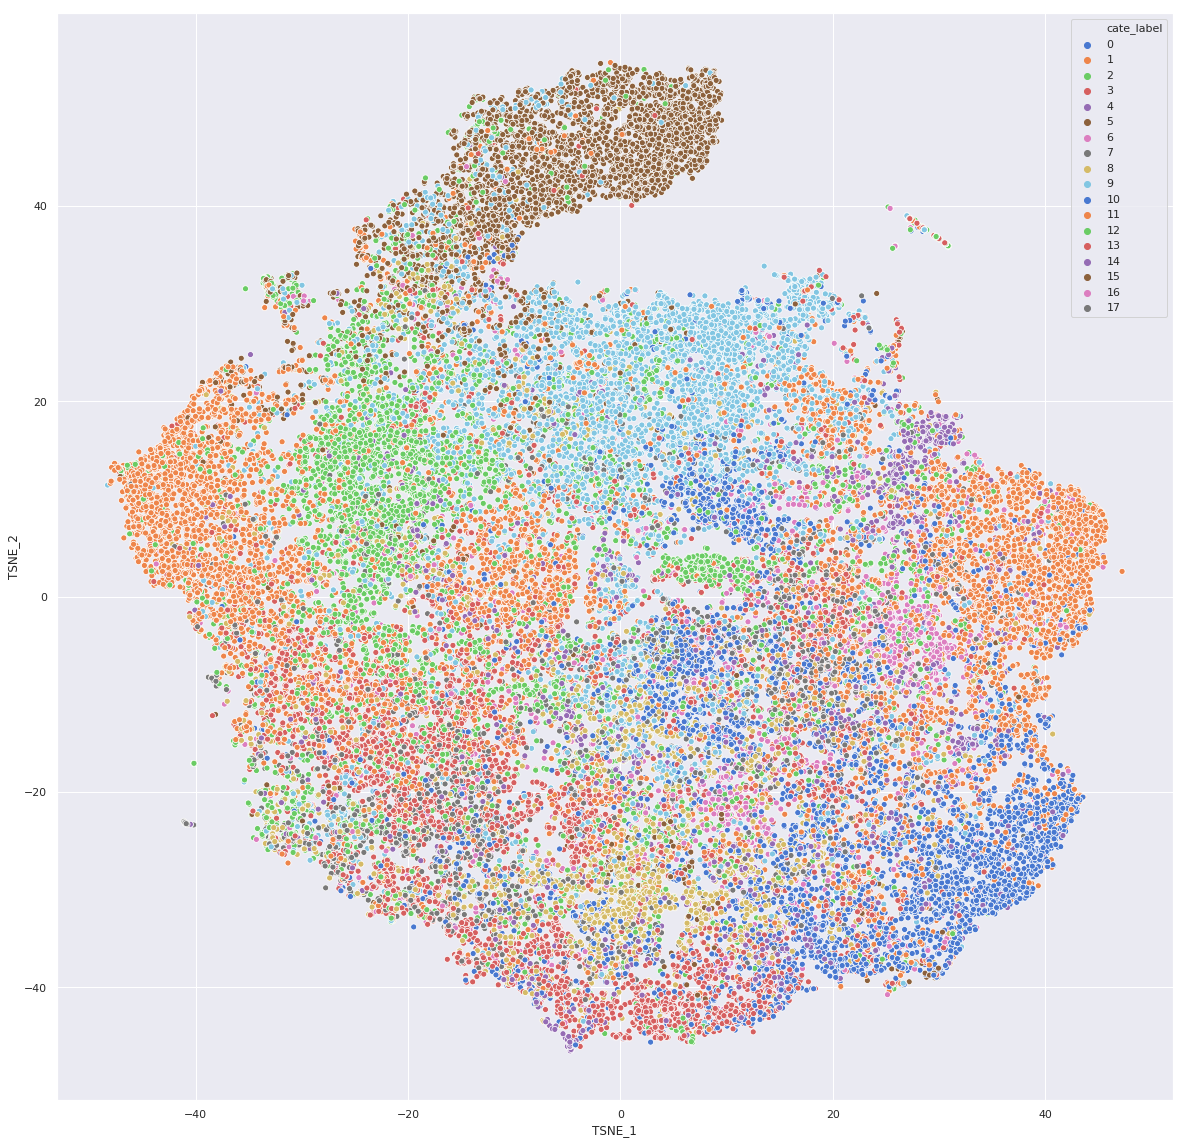

In [11]:
sns.set()
plt.figure(figsize=(20,20))
sns.scatterplot(
                x = df_bert_vector['TSNE_1'],
                y = df_bert_vector['TSNE_2'],
                hue = df_bert_vector['cate_label'],
                legend = 'full',
                palette = sns.color_palette("muted",n_colors = 18)
                )